**Hypothesis Generation**

Salary: applicants with higher income should have higher chances of loan approval <br>
Previous history: applicants who have repayed previous loans should have better chances <br>
Loan amount: lower loan amounts should have better chances of approval <br>
Loan terms: shorter tenors should have better chances of approval <br>
EMI: the lower the expected monthly installment for the applicant, compared to income, the better the approval chances <br>


In [1]:
#load packages
!pip install xgboost
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#make the visual to be stored in the notebook ?
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore") #to ignore deprecation warnings
print('setup complete')

     |████████████████████████████████| 127.6MB 4.1kB/s eta 0:00:01   |█                               | 3.8MB 2.2MB/s eta 0:00:58     |█████                           | 19.8MB 5.4MB/s eta 0:00:20     |██████                          | 23.5MB 5.4MB/s eta 0:00:20                  | 34.8MB 35.3MB/s eta 0:00:03                  | 36.3MB 15.5MB/s eta 0:00:06     |██████████                      | 39.9MB 2.3MB/s eta 0:00:38.6MB 2.3MB/s eta 0:00:37��█████▉                    | 47.2MB 504kB/s eta 0:02:40     |████████████                    | 48.0MB 504kB/s eta 0:02:38kB/s eta 0:02:36kB/s eta 0:01:5757kB/s eta 0:01:50████                  | 56.1MB 657kB/s eta 0:01:499MB/s eta 0:00:03████▊                | 62.7MB 31.9MB/s eta 0:00:03████▉                | 63.1MB 31.9MB/s eta 0:00:03████▉                | 63.3MB 31.9MB/s eta 0:00:03    |████████████████▉               | 67.2MB 13.8MB/s eta 0:00:05█████████████████               | 67.8MB 13.8MB/s eta 0:00:05��███████              | 71.9MB 13.8MB

In [2]:
#load train and test data
train = pd.read_csv("train_ctrUa4K.csv")
test = pd.read_csv("test_lAUu6dG.csv")

#make copies
train_original = train.copy()
test_original = test.copy()

**Understanding the Data**

we will inspect the content of the data

In [3]:
#inspect the columns and data types
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [4]:
#inspect test data 
test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [5]:
#train and test have similar content except of loan status which is the target variable. This is not present in test data
#now we inspect the data types of each column. This will help understand which data are categorical and which are numerical
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
#look at the shape of the dataset
train.shape, test.shape

((614, 13), (367, 12))

train has 614 rows and 13 columns
test has 367 rows and 12 columns

**Univariate Analysis**
<br>
In this type of analysis, we examine each variable individually

****Target Variable**** <br>
Let's do some analysis on loan_status. We'll look at it's frequency table, percentage distribution and bar plot

In [7]:
#frequency
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [8]:
#normalize can be set to True to print proportions instead of number
train['Loan_Status'].value_counts(normalize = True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

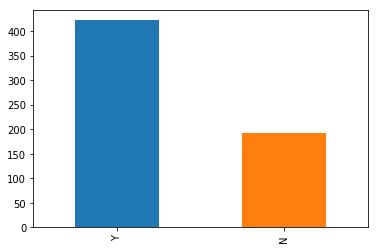

In [9]:
#do a bar graph of the normalized version
train['Loan_Status'].value_counts().plot.bar()

This shows that about 69% of applicants get approved <br>

Let's do other types of analyses: <br>
Categorical features: these features have categories (Gender, Married, Self_Employed, Credit_History, Loan_Status) <br>
Ordinal features: variables in categorical features having some order involved (Dependents, Education, Property_Area) <br>
Numerical features: these features have numerical values (ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term)

Let's visualize categorical and ordinal features first.

**Independent Variable (Categorical)**

<function matplotlib.pyplot.show(*args, **kw)>

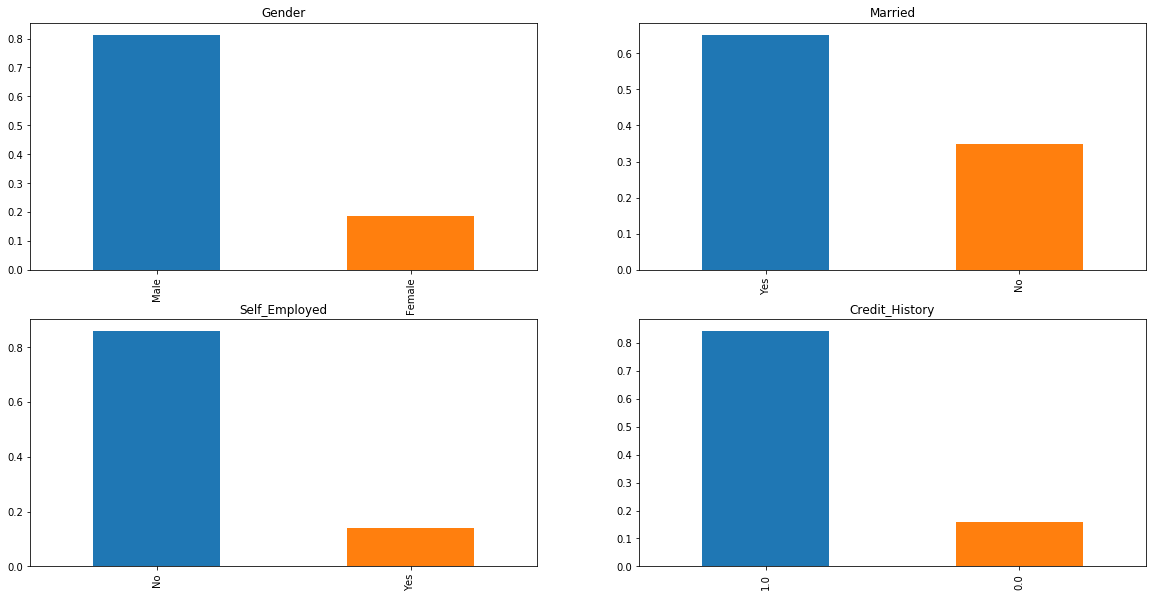

In [10]:
plt.figure(1)
plt.subplot(221)
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Gender')

plt.subplot(222)
train['Married'].value_counts(normalize=True).plot.bar(title='Married')

plt.subplot(223)
train['Self_Employed'].value_counts(normalize=True).plot.bar(title='Self_Employed')

plt.subplot(224) 
train['Credit_History'].value_counts(normalize=True).plot.bar(title='Credit_History')

plt.show

It can be inferred from these plots that:<br>
80% of applicants are male. <br>
About 65% are married. <br>
About 15% are self employed. <br>
Arount 85% have repaid their debts. <br>

Now let's visualize ordinal variables. <br>

**Independent Variable (Ordinal)**

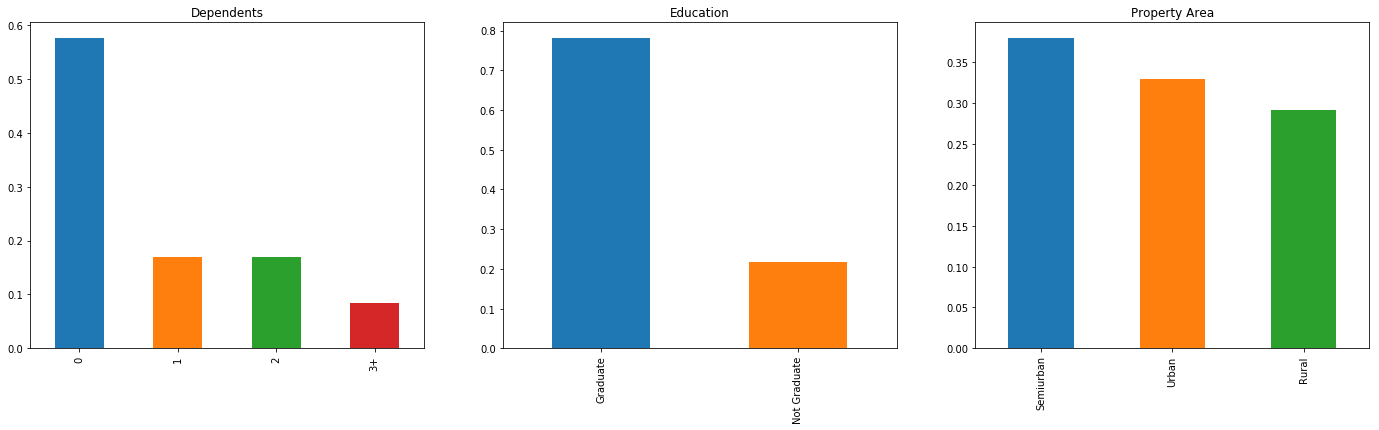

In [11]:
plt.figure(1)
plt.subplot(131)
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(24,6), title='Dependents')

plt.subplot(132)
train['Education'].value_counts(normalize=True).plot.bar(title='Education')

plt.subplot(133)
train['Property_Area'].value_counts(normalize=True).plot.bar(title='Property Area')

plt.show()

From the bar plots above, the following inferences can be made:<br>
Most applicants have no dependents. <br>
About 80% of applicants are graduates. <br>
Most applicants are from semi-urban areas <br>

**Independent Variable (Numerical)**

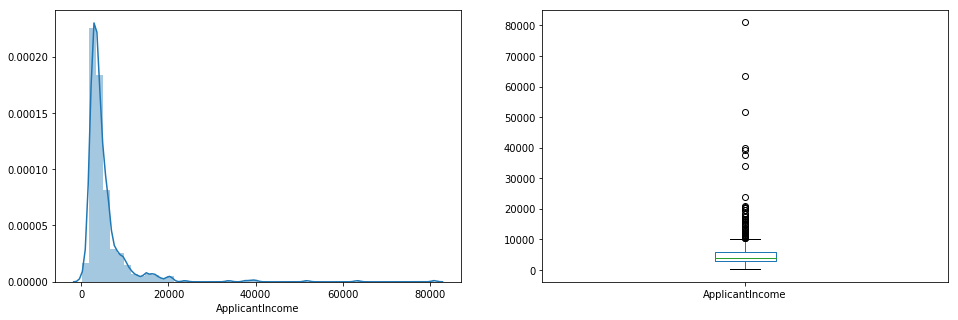

In [12]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train['ApplicantIncome']);

plt.subplot(122)
train['ApplicantIncome'].plot.box(figsize=(16,5))
plt.show()

The distribution of applicant income tends towards the left: it is not normally distributed. The box plot confirms the existence of outliers. The income disparity may be coming from the difference in education levels. Let's aggregate by education

Text(0.5, 0.98, '')

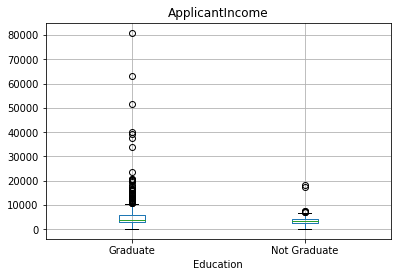

In [13]:
train.boxplot(column='ApplicantIncome', by='Education')
plt.suptitle("")

The outliers are coming from the graduate applicants. Let's look at coapplicant income

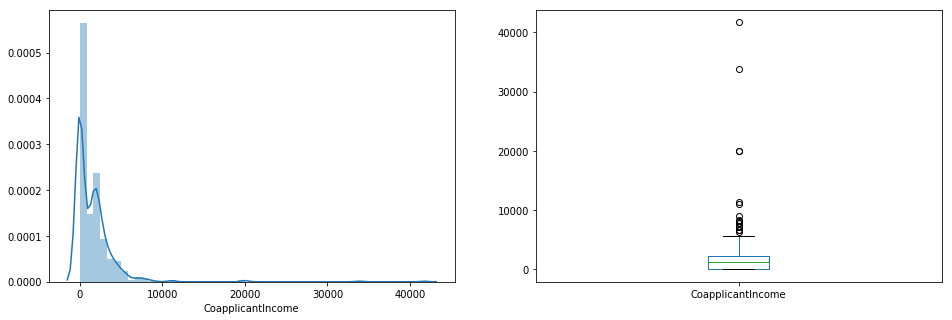

In [14]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train['CoapplicantIncome']);
plt.subplot(122)
train['CoapplicantIncome'].plot.box(figsize=(16,5))
plt.show()

Coapplicant income also contains outliers. <br>

Let's look at LoanAmount variable

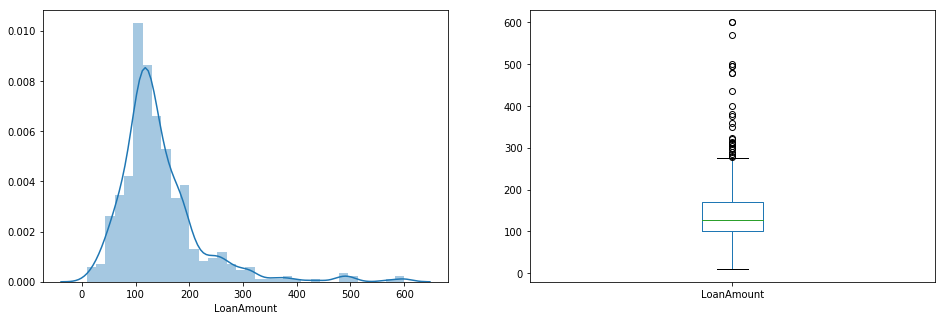

In [15]:
plt.figure(1)
plt.subplot(121)

df=train.dropna()
sns.distplot(df['LoanAmount']);
plt.subplot(122)
df['LoanAmount'].plot.box(figsize=(16,5))
plt.show()

There are some outliers here but the distribution is faily normal. We will handle outliers later in the notebook.<br>

**Bivariate Analysis**
Recall some of the hypotheses made at the beginning of this notebook: <br>
Salary: applicants with higher income should have higher chances of loan approval <br>
Previous history: applicants who have repayed previous loans should have better chances <br>
Loan amount: lower loan amounts should have better chances of approval <br>
EMI: the lower the expected monthly installment for the applicant, compared to income, the better the approval chances <br>

**Categorical Independent Variable vs Target Variable**


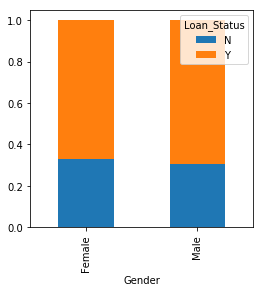

In [16]:
Gender=pd.crosstab(train['Gender'], train['Loan_Status'])
Gender.div(Gender.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))

It can be inferred that approval rate for both genders is basically the same. <br>

Let's visualize other categorical variables against target variable (Loan_Status)

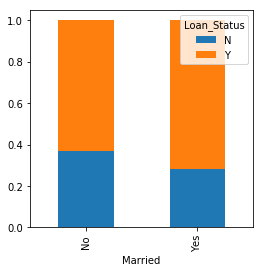

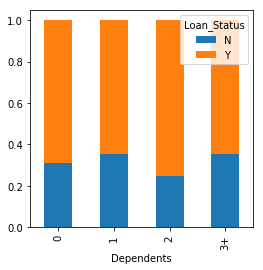

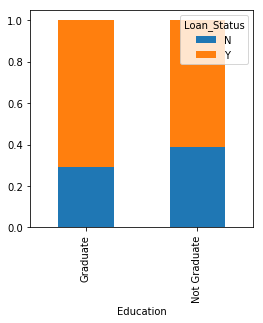

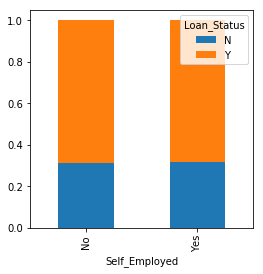

In [17]:
Married=pd.crosstab(train['Married'],train['Loan_Status'])
Dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
Education=pd.crosstab(train['Education'],train['Loan_Status'])
Self_Employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])

Married.div(Married.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()
Dependents.div(Dependents.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()
Education.div(Education.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()
Self_Employed.div(Self_Employed.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()

Married people tend to get more loans approved<br>
Graduates tend to get more loans approved

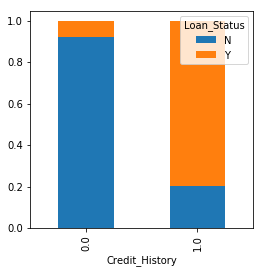

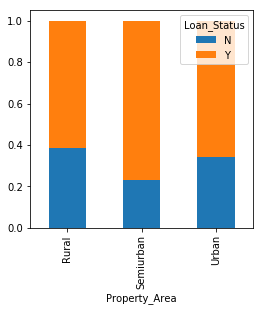

In [18]:
#Let's look at the relationship between the remaining categorical independent variables and loan status
Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Property_Area=pd.crosstab(train['Property_Area'],train['Loan_Status'])

Credit_History.div(Credit_History.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()
Property_Area.div(Property_Area.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True, figsize=(4,4))
plt.show()

People who have repaid old loans get loans much more than those who haven't <br>
Semi-urban dwellers get more loans approved than rural or urban dwellers

**Numerical Independent Variable vs Target Variable**


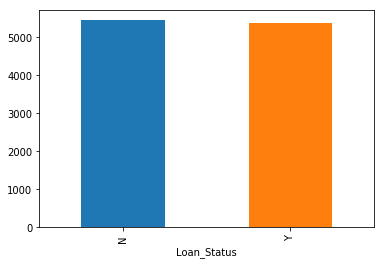

In [19]:
#calculate mean income grouped by approval status
train.groupby('Loan_Status').ApplicantIncome.mean().plot.bar()

This doesn't say much. Let's categorize income into bins and visualize again

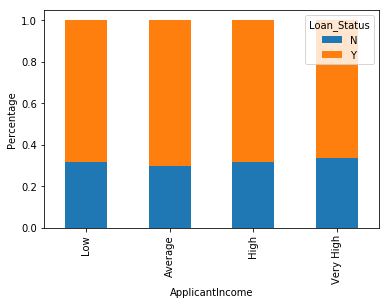

In [20]:
bins = [0,2500,4000,6000,81000] 
group = ['Low','Average','High','Very High']
train['Income_bin'] = pd.cut(train['ApplicantIncome'],bins,labels=group)

Income_bin = pd.crosstab(train['Income_bin'],train['Loan_Status'])
Income_bin.div(Income_bin.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True)
plt.xlabel('ApplicantIncome')
P = plt.ylabel('Percentage')

This shows that applicant income does not affect the chances of loan approval, contradicting the hypothesis that says higher income will increase chances of loan approval. <br>
Let's analyze coapplicant income as well

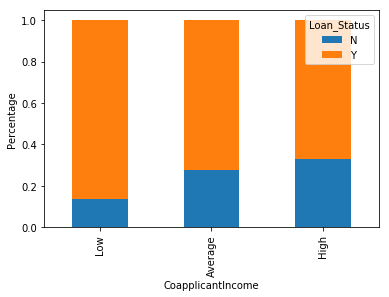

In [21]:
bins = [0,1000,3000,42000]
group = ['Low','Average','High']
train['Coapplicant_Income_bin'] = pd.cut(train['CoapplicantIncome'],bins,labels=group)

Coapplicant_Income_bin = pd.crosstab(train['Coapplicant_Income_bin'],train['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True)
plt.xlabel('CoapplicantIncome')
P = plt.ylabel('Percentage')

lower coapplicant income improves chances of loan approval <br>
wow! <br>
so it seems many applicants don't have a coapplicant making that value 0. <br>
so let's combine applicant income and coapplicant income instead

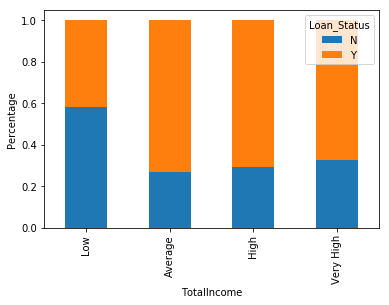

In [22]:
train['Total_Income'] = train['ApplicantIncome']+train['CoapplicantIncome']

bins = [0,2500,4000,6000,81000]
group = ['Low','Average','High','Very High']
train['Total_Income_bin']=pd.cut(train['Total_Income'],bins,labels=group)

Total_Income_bin = pd.crosstab(train['Total_Income_bin'],train['Loan_Status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True)
plt.xlabel('TotalIncome')
P=plt.ylabel('Percentage')

low income earners have the least chances of loan approval. The proportions are quite significant <br>
Average income earners have the best chances of loan approval, although not by much<br>

Let's visualize the loan amounts

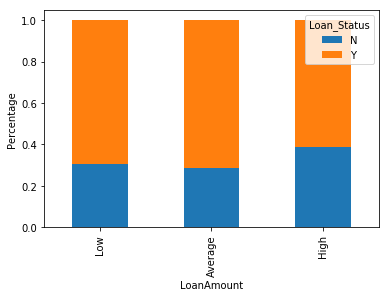

In [23]:
bins = [0,100,200,700]
group = ['Low','Average','High']

train['LoanAmount_bin'] = pd.cut(train['LoanAmount'],bins,labels=group)
LoanAmount_bin = pd.crosstab(train['LoanAmount_bin'],train['Loan_Status'])
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True)
plt.xlabel('LoanAmount')
P=plt.ylabel('Percentage')

The lower the loan amount, the higher the chances for loan approval. This supports one of the hypotheses.

Let's drop the bins. We will also change the "3+" in dependents to 3 to make it numerical. Let's also convert the target variable's categories to 0 and 1 so that we can find it's correlation to numerical variables.

It will also help with logistic regression modelling which takes only numeric inputs

In [24]:
train = train.drop(['Income_bin','Coapplicant_Income_bin','LoanAmount_bin','Total_Income_bin','Total_Income'], axis=1)


In [25]:
train['Dependents'].replace('3+',3,inplace=True)
test['Dependents'].replace('3+',3,inplace=True)
train['Loan_Status'].replace('N',0,inplace=True)
train['Loan_Status'].replace('Y',1,inplace=True)

Let's use a heat map to visualize the correlation between the numeric variables now

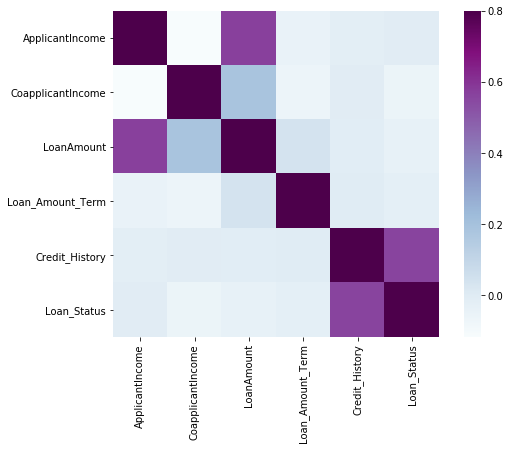

In [26]:
matrix = train.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu")

The most correlated variables are ApplicantIncome and LoanAmount sa well Credit_History and Loan_Status

After exploring the variables in our data set, let's imput missing values and handle the outliers

**Missing Value Imputation**


In [27]:
#list out the feature-wise count of missing values
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are missing values in Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term and Credit_History.

I'll consider these methods:

For numerical variables: imputation using median or mode <br>
For categorical variables: imputation using mode

In [28]:
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

In [29]:
#check the frequency of occurence of Loan_Amount_Term to decide what method to use
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

360 days is the most frequent. I'll replace missing values with mode

In [30]:
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

In [31]:
#let's use median to fill missing values in LoanAmount because we saw in the analyses earlier that it has outliers
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

In [32]:
#confirm that all missing values have been filled
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [33]:
#all missing values in the train dataset have been handled. let's do the same for the test dataset
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)
test['Married'].fillna(test['Married'].mode()[0], inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mode()[0], inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].median(), inplace=True)

**Outlier Treatment**

Let's take the log transformation for LoanAmount so we can handle outliers

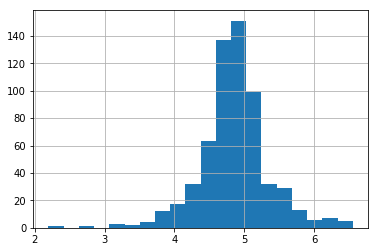

In [34]:
#we'll do this for both train and test data sets
train['LoanAmount_log'] = np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)
test['LoanAmount_log'] = np.log(test['LoanAmount'])

This distribution now looks closer to normal and the effect of extreme values has been reduced significantly.

**MODEL BUILDING**

We'll use logistic regression in this first part of model building.

Let's drop Loan_ID variable. It has no effect on the prediction of Loan_Status

In [35]:
#drop Loan_ID for both train and test data sets
train=train.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)

In [36]:
#let's take out Loan_Status from the train data set and put it in another data set
X = train.drop('Loan_Status',axis=1)
y = train['Loan_Status']

In [37]:
#Let's make dummy values for the categorical variables
X = pd.get_dummies(X)
train = pd.get_dummies(train)
test = pd.get_dummies(test)


In [38]:
X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,128.0,360.0,1.0,4.852030,0,1,1,0,...,1,0,0,1,0,1,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,4.852030,0,1,0,1,...,0,1,0,1,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,4.189655,0,1,0,1,...,1,0,0,1,0,0,1,0,0,1
3,2583,2358.0,120.0,360.0,1.0,4.787492,0,1,0,1,...,1,0,0,0,1,1,0,0,0,1
4,6000,0.0,141.0,360.0,1.0,4.948760,0,1,1,0,...,1,0,0,1,0,1,0,0,0,1


In [39]:
#no we do a train test split and train the model
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3)


In [40]:
#import logictic regression and accuracy score modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, 
multi_class='ovr', n_jobs=1,penalty='l2', random_state=1, solver='liblinear', tol=0.0001,verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Here the C parameter represents inverse of regularization strength. Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. Smaller values of C specify stronger regularization. 

In [41]:
#let's make a prediction
pred = model.predict(X_valid)

In [42]:
accuracy_score(y_valid,pred)

0.8054054054054054

So we're 81% accurate. We've identified 81% of Loan_Status accurately. Let's make predictions on the test dataset

In [43]:
pred_test = model.predict(test)

In [44]:
#let me prepare the submission file. I'll load the sample submission file and replace the content
submission = pd.read_csv("sample_submission_49d68Cx.csv")

In [45]:
submission['Loan_Status']=pred_test 
submission['Loan_ID']=test_original['Loan_ID']

In [46]:
#We need predictions in Y and N. So let’s convert 1 and 0 to Y and N.

submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

In [47]:
#I'll save to csv format
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv("logistic.csv", index=False)

**Logistic Regression using stratified k-folds cross validation**



In [48]:
from sklearn.model_selection import StratifiedKFold

In [49]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))    
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = LogisticRegression(random_state=1)    
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.7983870967741935

2 of kfold 5
accuracy_score 0.8306451612903226

3 of kfold 5
accuracy_score 0.8114754098360656

4 of kfold 5
accuracy_score 0.7950819672131147

5 of kfold 5
accuracy_score 0.8278688524590164


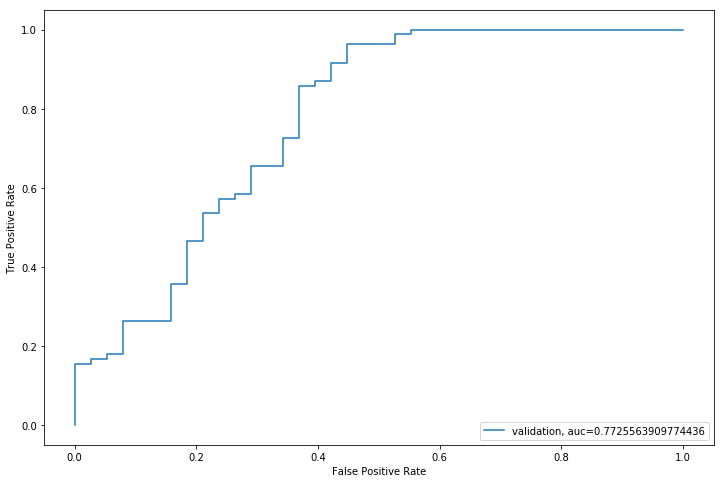

In [50]:
#let's visualize the ROC curve
from sklearn import metrics 
fpr, tpr, _ = metrics.roc_curve(yvl,  pred) 
auc = metrics.roc_auc_score(yvl, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="validation, auc="+str(auc)) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [51]:
#let's prepare the submission file
submission['Loan_Status']=pred_test 
submission['Loan_ID']=test_original['Loan_ID']


In [52]:
#use Y and N
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

In [53]:
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('Logistic.csv', index=False)


**Feature Engineering**

Total Income - As discussed during bivariate analysis we will combine the Applicant Income and Coapplicant Income. If the total income is high, chances of loan approval might also be high.


EMI - EMI is the monthly amount to be paid by the applicant to repay the loan. Idea behind making this variable is that people who have high EMI’s might find it difficult to pay back the loan. We can calculate the EMI by taking the ratio of loan amount with respect to loan amount term.


Balance Income - This is the income left after the EMI has been paid. Idea behind creating this variable is that if this value is high, the chances are high that a person will repay the loan and hence increasing the chances of loan approval.

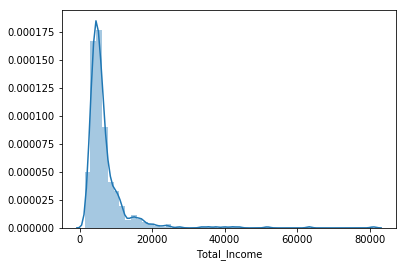

In [54]:
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome'] 
test['Total_Income']=test['ApplicantIncome']+test['CoapplicantIncome']

sns.distplot(train['Total_Income']);


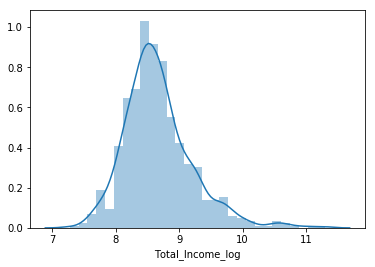

In [55]:
#the distribution is right skewed. Let's take the log transformation to make the distribution more normal
train['Total_Income_log'] = np.log(train['Total_Income']) 
sns.distplot(train['Total_Income_log']); 
test['Total_Income_log'] = np.log(test['Total_Income'])

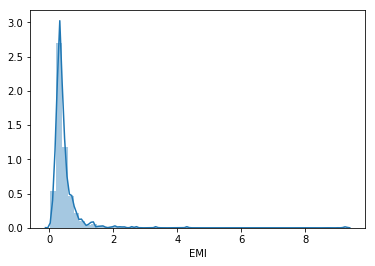

In [56]:
#Let's create the EMI feature
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term'] 
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']
sns.distplot(train['EMI'])

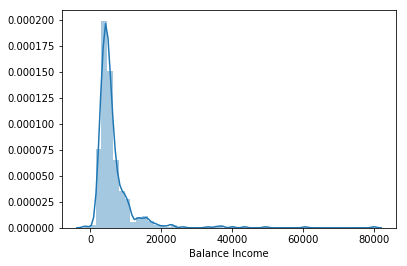

In [57]:
#Let us create Balance Income feature now and check its distribution.

train['Balance Income']=train['Total_Income']-(train['EMI']*1000) # Multiply with 1000 to make the units equal 
test['Balance Income']=test['Total_Income']-(test['EMI']*1000)
sns.distplot(train['Balance Income']);

In [58]:
#Let's drop the old variables used to create these new features to avoid noise in the data set
train=train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1) 
test=test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

**Model Building : Part II**

We will build the following models in this section:

Logistic Regression<br>
Decision Tree<br>
Random Forest<br>
XGBoost<br>

In [59]:
#prepare the data
X = train.drop('Loan_Status',1) 
y = train.Loan_Status   

***Logistic Regression***

In [60]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]   
    
    model = LogisticRegression(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.8064516129032258

2 of kfold 5
accuracy_score 0.8225806451612904

3 of kfold 5
accuracy_score 0.7786885245901639

4 of kfold 5
accuracy_score 0.7868852459016393

5 of kfold 5
accuracy_score 0.819672131147541


In [61]:
submission['Loan_Status']=pred_test            # filling Loan_Status with predictions 
submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID
# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('Log2.csv', index=False)

score after submission was 0.77. Feature engineering hasn't improved the score. Let's try other algorithms

***Decision Tree***

In [62]:
from sklearn import tree

In [63]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y): 
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = tree.DecisionTreeClassifier(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test)


1 of kfold 5
accuracy_score 0.7258064516129032

2 of kfold 5
accuracy_score 0.7419354838709677

3 of kfold 5
accuracy_score 0.7049180327868853

4 of kfold 5
accuracy_score 0.680327868852459

5 of kfold 5
accuracy_score 0.7049180327868853


In [64]:
submission['Loan_Status']=pred_test            # filling Loan_Status with predictions 
submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID
# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('Decision Tree.csv', index=False)

Score after submission is 0.64. This is worse. Let's try another algorithm

***Random Forests***


In [65]:
from sklearn.ensemble import RandomForestClassifier
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):    
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = RandomForestClassifier(random_state=1, max_depth=10)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 


1 of kfold 5
accuracy_score 0.8225806451612904

2 of kfold 5
accuracy_score 0.8145161290322581

3 of kfold 5
accuracy_score 0.7377049180327869

4 of kfold 5
accuracy_score 0.7295081967213115

5 of kfold 5
accuracy_score 0.8114754098360656


The mean validation accuracy for this model is 0.766

We will try to improve the accuracy by tuning the hyperparameters for this model. We will use grid search to get the optimized values of hyper parameters. Grid-search is a way to select the best of a family of hyper parameters, parametrized by a grid of parameters.

We will tune the max_depth and n_estimators parameters. max_depth decides the maximum depth of the tree and n_estimators decides the number of trees that will be used in random forest model.

In [66]:
from sklearn.model_selection import GridSearchCV

# Provide range for max_depth from 1 to 20 with an interval of 2 and from 1 to 200 with an interval of 20 for n_estimators 
paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)

from sklearn.model_selection import train_test_split 
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3, random_state=1)

# Fit the grid search model 
grid_search.fit(x_train,y_train)
GridSearchCV(cv=None, error_score='raise', estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',            max_depth=None, max_features='auto', max_leaf_nodes=None,            min_impurity_decrease=0.0, min_impurity_split=None,            min_samples_leaf=1, min_samples_split=2,            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,            oob_score=False, random_state=1, verbose=0, warm_start=False),       
fit_params=None, iid=True, n_jobs=1, param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181]},       
pre_dispatch='2*n_jobs', refit=True, return_train_score='warn', scoring=None, verbose=0)

# Estimating the optimized value 
grid_search.best_estimator_
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=3, max_features='auto', max_leaf_nodes=None,            min_impurity_decrease=0.0, min_impurity_split=None,            
min_samples_leaf=1, min_samples_split=2,            
min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=1,            
oob_score=False, random_state=1, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [67]:
#So, the optimized value for the max_depth variable is 3 and for n_estimator is 41. 
#Now let’s build the model using these optimized values.

i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):    
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = RandomForestClassifier(random_state=1, max_depth=3, n_estimators=41)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred2=model.predict_proba(test)[:,1]


1 of kfold 5
accuracy_score 0.7983870967741935

2 of kfold 5
accuracy_score 0.8225806451612904

3 of kfold 5
accuracy_score 0.8032786885245902

4 of kfold 5
accuracy_score 0.7786885245901639

5 of kfold 5
accuracy_score 0.819672131147541


In [68]:
submission['Loan_Status']=pred_test            # filling Loan_Status with predictions 
submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID
# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('Random Forest.csv', index=False)

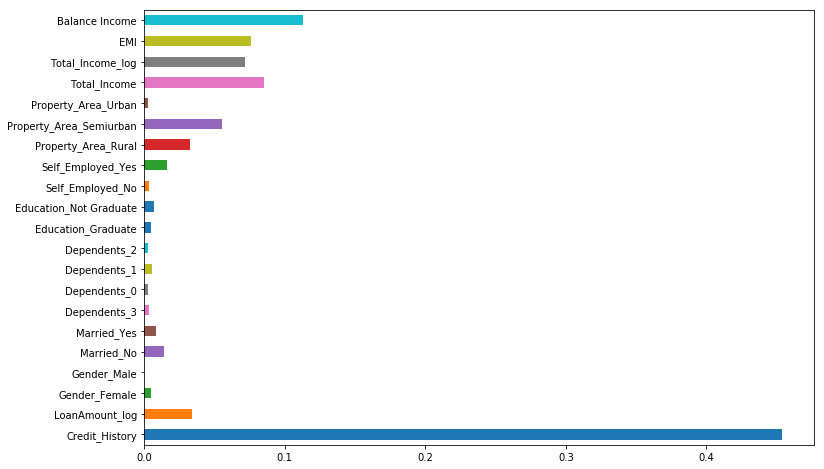

In [69]:
#score after submission if 0.76

#let's check feature importance

importances=pd.Series(model.feature_importances_, index=X.columns) 
importances.plot(kind='barh', figsize=(12,8))

We can see that Credit_History is the most important feature followed by Balance Income, Total Income, EMI. So, feature engineering helped us in predicting our target variable.

***XGBoost***

In [72]:
from xgboost import XGBClassifier
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y[train_index],y[test_index]         
    model = XGBClassifier(n_estimators=50, max_depth=4)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
    pred_test = model.predict(test) 
    pred3=model.predict_proba(test)[:,1]



1 of kfold 5
accuracy_score 0.75

2 of kfold 5
accuracy_score 0.8225806451612904

3 of kfold 5
accuracy_score 0.7377049180327869

4 of kfold 5
accuracy_score 0.7622950819672131

5 of kfold 5
accuracy_score 0.7786885245901639


In [73]:
submission['Loan_Status']=pred_test            # filling Loan_Status with predictions 
submission['Loan_ID']=test_original['Loan_ID'] # filling Loan_ID with test Loan_ID
# replacing 0 and 1 with N and Y 
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)
# Converting submission file to .csv format 
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status']).to_csv('xgboost.csv', index=False)

got a score of 0.69 after submission to the hackathon